In [ ]:
pip install gdown

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import re
from PIL import Image  #Python Imaging Library
import cv2
import copy
import zipfile
import gdown
import albumentations as A
import random
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential

In [ ]:
url = 'https://zenodo.org/record/6542933/files/MarsSampleLocalization_Dataset.zip?download=1'
output = 'data.zip'
gdown.download(url, output, quiet = False)
zip_ = zipfile.ZipFile('data.zip')
zip_.extractall()
zip_.close()

In [2]:
# correr esta célula apenas se o dataset estiver na drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Este pedaço de código é destinado a aceder à pasta do dataset, portanto pode ser diferente de user para user
%cd /content/drive/MyDrive/Colab Notebooks/MarsSampleLocalization_Dataset

/content/drive/MyDrive/Colab Notebooks/MarsSampleLocalization_Dataset


### **Primeiro foi feito tudo para a parte real do dataset e só depois é que se juntou a parte sintética. Daí algumas funções criadas terem sido adaptadas para a parte sintética**

## **Primeiro passo**: Mudar os endereços das imagens para algo acessível







In [4]:
# função que devolve os novos paths das imagens, para que sejam mais acessíveis

def list_from_darknetlabels(image_type, set_type):

  f = open('./train_images/darknet_labels/' + image_type + '_' + set_type + '.txt', 'r')
  lines_list = f.readlines()
  f.close()

  vector = []

  for line in lines_list:

      my_regex = re.compile("((?<=datasets/).*).png")   # positive lookbehind
      m_1 = my_regex.search(line)
      m_2 = m_1.group(0)
      path = './' + m_2
      vector.append(path)

  return vector

In [5]:
# para as imagens de train e valid reais, respetivamente

real_train_list = list_from_darknetlabels('real', 'train')
real_valid_list = list_from_darknetlabels('real', 'valid')
real_valid_list[0]

'./train_images/real/valid/Treal_N5.png'

## **Segundo passo**: Feature extraction
As imagens alteradas farão parte, na forma de tensores, de X_train_real e X_val_real

In [6]:
# guardar as shapes das imagens de train_real e valid_real, que são iguais, antes de darem resize

image = cv2.imread(real_valid_list[0])
shape_before = image.shape
shape_before

(768, 1024, 3)

In [7]:
# função que vai criar X_train e X_val, em forma de np.array

def img_to_array_modified(vector):

  X = []

  for img_path in vector:

      img_arr = cv2.imread(img_path)
      img_arr = cv2.resize(img_arr,(224,224))
      img_normalized = cv2.normalize(img_arr, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
      X.append(img_normalized)

  return np.array(X)

In [8]:
# criar X_train_real e X_val_real e verificar a shape atual de ambos

X_train_real = img_to_array_modified(real_train_list)
X_val_real = img_to_array_modified(real_valid_list)

shape_after = (X_train_real.shape[1], X_train_real.shape[2], X_train_real.shape[3])

print(X_train_real.shape, X_val_real.shape)

(49, 224, 224, 3) (6, 224, 224, 3)


## **Terceiro passo**: Normalizar os valores da dataframe e adaptar de seguida para a shape 224x224 das imagens, em busca de y_train e y_val
Através do csv file que contém as coordenadas das bounding boxes nas imagens com shape 1024x768, normaliza-se estas coordenadas para depois ficarem adaptadas às imagens com novo shape 224x224

In [9]:
# preparar a dataframe a partir do csv file que contém as coordenadas das bounding boxes de train e val,
# adaptado para sintético e real
# os nomes das imagens .png serão o índice da df e faremos drop da coluna label

def prepare_df(image_type):

  if image_type == 'real':
    df = pd.read_csv('./train_images/real/real_scene.csv')

  else:
    df = pd.read_csv('./train_images/synthetic/synthetic_scene.csv')

  df.set_index('image', inplace=True)
  df.drop('label', axis=1, inplace=True)

  return df

In [10]:
df_real = prepare_df('real')
df_real[:2]

,xmin,ymin,xmax,ymax
image,,,,
Treal_N11.png,418.660017,40.017738,461.220283,53.640798
Treal_N1.png,529.316708,497.241685,604.222776,545.773836


In [11]:
# shape_before = (768, 1024, 3), calculado anteriormente

def normalize_df(df):

  for i, column in enumerate(df.columns):

      if column == 'xmin' or column == 'xmax':
        df[column] /= shape_before[1]  # normaliza-se os valores

      else:
        df[column] /= shape_before[0]

  return df

In [12]:
df_real = normalize_df(df_real)
df_real[:2]

,xmin,ymin,xmax,ymax
image,,,,
Treal_N11.png,0.408848,0.052106,0.450410,0.069845
Treal_N1.png,0.516911,0.647450,0.590061,0.710643


## **Quarto passo**: Criar y_train e y_val a partir dos valores ajustados para as imagens de 224x224 da dataframe

In [13]:
# a função que se segue a esta célula foi generalizada para a parte sintética do dataset,
# sendo por isso necessário correr previamente o seguinte código

synthetic_train_list = list_from_darknetlabels('synthetic', 'train')
synthetic_valid_list = list_from_darknetlabels('synthetic', 'valid')

In [14]:
# como as imagens de train e valid estão misturadas na dataframe, é necessário
# separá-las em duas dataframes distintas, df_train e df_val

# função que separa a dataframe em duas

def separate_df(list):

  image_index = []

  for line in list:

      if list == real_valid_list or list == synthetic_valid_list:
        reg_ex = "((?<=valid/).*)"

      else:
        reg_ex = "((?<=train/).*)"

      my_regex = re.compile(reg_ex)
      m_1 = my_regex.search(line)
      m_2 = m_1.group(0)
      image_index.append(m_2)

  if list == real_valid_list or list == real_train_list:
    df = df_real.loc[image_index]

  else:
    df = df_synthetic.loc[image_index]

  return df

In [15]:
# cria-se as dataframes df_train_real e df_val_real

df_train_real = separate_df(real_train_list)
df_val_real = separate_df(real_valid_list)
df_val_real[:2]

,xmin,ymin,xmax,ymax
image,,,,
Treal_N5.png,0.660718,0.876940,0.750494,0.962306
Treal_N21.png,0.938357,0.307095,0.965789,0.342572


In [16]:
# a partir das dataframes criadas, prepara-se o y_train e y_val, em forma de np.array
# função que cria o y_train e y_val, dependendo do input df que se lhe dá

def y_set(df):

  y = []

  for i in range(df.shape[0]):
      vector = []

      for j in range(df.shape[1]):
          vector.append(df.iloc[i,j])

      y.append(vector)

  return np.array(y)

In [17]:
# criar y_train_real e y_val_real, verificando a shape de ambos

y_train_real = y_set(df_train_real)
y_val_real = y_set(df_val_real)
print(y_train_real.shape, y_val_real.shape)

y_train_real[:2], y_val_real[:2]

(49, 4) (6, 4)


(array([[0.51691085, 0.64745011, 0.59006131, 0.71064302],
        [0.70809954, 0.48669623, 0.84775042, 0.62084257]]),
 array([[0.660718  , 0.87694013, 0.75049356, 0.96230599],
        [0.93835723, 0.30709534, 0.96578865, 0.34257206]]))

**------ Apenas a verificar se está a construir a bounding box num dos exemplos do train -------**

In [18]:
def show_image_bbox(X_arr, bbox, new_img_path):

  # os valores da bbox têm de entrar normalizados

  shape_after = X_arr.shape

  bbox_ = copy.deepcopy(bbox)
  pil_img = tf.keras.utils.array_to_img(X_arr)  # esta função tira a normalização do array (não tem muito problema dado que esta função é apenas para demonstração, no modelo entram os valores normalizados)
  pil_img_tiny = pil_img

  tf.keras.utils.save_img(new_img_path, pil_img_tiny)

  if len(bbox_) != 0:
    bbox_[0] *= shape_after[1]
    bbox_[1] *= shape_after[0]
    bbox_[2] *= shape_after[1]
    bbox_[3] *= shape_after[0]

    start_point = (int(bbox_[0]), int(bbox_[1]))
    end_point = (int(bbox_[2]), int(bbox_[3]))

  color = (255,0,0)  # RGB, fica vermelho desta forma
  thickness = 1

  image = cv2.imread('./' + new_img_path)

  if len(bbox_) != 0:
    image = cv2.rectangle(image, start_point, end_point, color, thickness)  # tem de se usar valores inteiros aqui
    image = cv2.putText(image, 'sample', (int(bbox_[0]), int(bbox_[1] - 3)), 0, 0.3, (255,0,0), 1)

  pil_img = tf.keras.utils.array_to_img(image)

  return pil_img

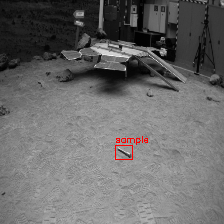

In [19]:
show_image_bbox(X_train_real[0], y_train_real[0], 'tinyTreal_N1.png')

## **Quinto passo**: Criar X_train e X_val, ao adicionar a X_train_real e X_val_real a parte sintética do dataset

**--- 1º ---**

In [20]:
# código já corrido lá em cima

synthetic_train_list = list_from_darknetlabels('synthetic', 'train')
synthetic_valid_list = list_from_darknetlabels('synthetic', 'valid')

**--- 2º ---**

In [21]:
# guardar as shapes das imagens de train e valid, que são iguais, antes de darem resize

image = cv2.imread(synthetic_valid_list[0])
shape_before = image.shape
shape_before

(720, 1280, 3)

In [22]:
X_train_syn = img_to_array_modified(synthetic_train_list)
X_val_syn = img_to_array_modified(synthetic_valid_list)

In [23]:
shape_after = (X_train_syn.shape[1], X_train_syn.shape[2], X_train_syn.shape[3])

print(X_train_syn.shape, X_val_syn.shape)

(542, 224, 224, 3) (60, 224, 224, 3)


**--- 3º ---**

In [24]:
df_synthetic = prepare_df('synthetic')
df_synthetic[:2]

,xmin,ymin,xmax,ymax
image,,,,
Tsyn_N104.png,743.652653,375.965074,773.645762,385.670956
Tsyn_N463.png,761.662246,373.691038,793.351017,396.332547


In [25]:
df_synthetic = normalize_df(df_synthetic)
df_synthetic[:2]

,xmin,ymin,xmax,ymax
image,,,,
Tsyn_N104.png,0.580979,0.522174,0.604411,0.535654
Tsyn_N463.png,0.595049,0.519015,0.619805,0.550462


**--- 4º ---**

In [26]:
df_train_syn = separate_df(synthetic_train_list)
df_val_syn = separate_df(synthetic_valid_list)
df_val_syn[:2]

,xmin,ymin,xmax,ymax
image,,,,
Tsyn_N9.png,0.622498,0.584701,0.657695,0.594517
Tsyn_N15.png,0.316770,0.542983,0.339545,0.556480


In [27]:
y_train_syn = y_set(df_train_syn)
y_val_syn = y_set(df_val_syn)
print(y_train_syn.shape, y_val_syn.shape)

y_train_syn[:2], y_val_syn[:2]

(542, 4) (60, 4)


(array([[0.60248447, 0.49513037, 0.63216011, 0.5086273 ],
        [0.57556936, 0.56629601, 0.59903382, 0.58347393]]),
 array([[0.62249827, 0.58470092, 0.65769496, 0.59451687],
        [0.31677019, 0.54298313, 0.33954451, 0.55648006]]))

**--- 5º ---**

In [28]:
# criar o X_train, X_val, y_train e y_val final com as imagens reais e sintéticas

X_train = np.concatenate([X_train_real, X_train_syn])
y_train = np.concatenate([y_train_real, y_train_syn])
X_val = np.concatenate([X_val_real, X_val_syn])
y_val = np.concatenate([y_val_real, y_val_syn])

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(591, 224, 224, 3) (591, 4) (66, 224, 224, 3) (66, 4)


**----- Apenas a verificar se está a construir a bounding box num dos exemplos do synthetic -----**

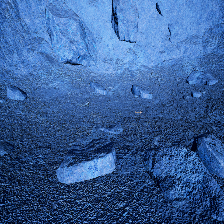

In [29]:
pil_img = tf.keras.utils.array_to_img(X_train[49])
pil_img_tiny = pil_img
pil_img_tiny

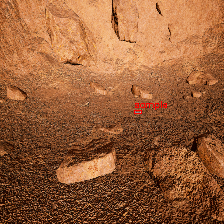

In [31]:
show_image_bbox(X_train[49], y_train[49], 'tinyTsyn_N104.png') # está a perder a normalização por causa do cv2.imread()

## **Sexto passo**: Construir o modelo

In [32]:
!pip install tensorflow-addons==0.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.5 MB/s eta 0:00:00


In [33]:
#from tensorflow import keras
#from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
#from keras.models import Sequential
#from tensorflow.keras.applications.vgg19 import VGG19
#from tensorflow.keras.applications.vgg19 import preprocess_input
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
# L2 loss, não foi usado no modelo
import tensorflow as tf

def custom_loss_with_l2_reg(lambda_value):
    def loss(y_true, y_pred):
        l2_loss = tf.add_n([tf.nn.l2_loss(w) for w in model.trainable_weights])
        return tf.reduce_mean(tf.square(y_true - y_pred)) + lambda_value * l2_loss
    return loss

lambda_value = 0.01
loss_fn = custom_loss_with_l2_reg(lambda_value)

In [43]:
model = Sequential([

    Conv2D(filters=16,kernel_size=(3,3),  input_shape = (224, 224, 3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='sigmoid')
])

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 54, 54, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)       

In [45]:
model.compile(optimizer='adam',
              loss=tfa.losses.GIoULoss(),
              metrics=['accuracy'])

In [51]:
model.fit(X_train, y_train, epochs=50, batch_size = 25)

Epoch 1/50
24/24 [==============================] - 35s 1s/step - loss: 0.9988 - accuracy: 0.5161
Epoch 2/50
24/24 [==============================] - 45s 2s/step - loss: 0.9988 - accuracy: 0.5381
Epoch 3/50
24/24 [==============================] - 34s 1s/step - loss: 0.9988 - accuracy: 0.5212
Epoch 4/50
24/24 [==============================] - 36s 1s/step - loss: 0.9988 - accuracy: 0.5059
Epoch 5/50
24/24 [==============================] - 34s 1s/step - loss: 0.9988 - accuracy: 0.5313
Epoch 6/50
24/24 [==============================] - 33s 1s/step - loss: 0.9994 - accuracy: 0.4992
Epoch 7/50
24/24 [==============================] - 35s 1s/step - loss: 0.9988 - accuracy: 0.4856
Epoch 8/50
24/24 [==============================] - 35s 1s/step - loss: 0.9988 - accuracy: 0.5093
Epoch 9/50
24/24 [==============================] - 33s 1s/step - loss: 1.0003 - accuracy: 0.5127
Epoch 10/50
24/24 [==============================] - 33s 1s/step - loss: 0.9988 - accuracy: 0.5228
Epoch 11/50
24/24 [

KeyboardInterrupt: ignored

In [47]:
score = model.evaluate(X_val, y_val, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.9992840886116028 / Test accuracy: 0.4848484992980957


In [48]:
y_pred = model.predict(X_val)
y_pred

3/3 [==============================] - 1s 249ms/step


array([[2.56011279e-09, 8.31761812e-11, 1.00000000e+00, 1.00000000e+00],
       [3.77292989e-12, 3.45802759e-14, 1.00000000e+00, 1.00000000e+00],
       [1.24956387e-13, 6.40360137e-16, 1.00000000e+00, 1.00000000e+00],
       [2.07233994e-10, 3.63418844e-12, 1.00000000e+00, 1.00000000e+00],
       [8.74753880e-10, 2.09174587e-11, 1.00000000e+00, 1.00000000e+00],
       [3.82376075e-11, 5.37997110e-13, 1.00000000e+00, 1.00000000e+00],
       [1.27118663e-10, 3.75213966e-12, 1.00000000e+00, 1.00000000e+00],
       [5.07943134e-13, 4.08688654e-15, 1.00000000e+00, 1.00000000e+00],
       [2.73306905e-10, 8.50340111e-12, 1.00000000e+00, 1.00000000e+00],
       [1.14952630e-13, 7.00355746e-16, 1.00000000e+00, 1.00000000e+00],
       [7.93193161e-14, 5.04310711e-16, 1.00000000e+00, 1.00000000e+00],
       [2.08035642e-13, 1.65575512e-15, 1.00000000e+00, 1.00000000e+00],
       [3.00001885e-13, 2.51581279e-15, 1.00000000e+00, 1.00000000e+00],
       [8.20426038e-09, 4.70350536e-10, 9.99999940e

In [40]:
y_pred[4]

array([1.000000e+00, 1.000000e+00, 9.043364e-13, 3.808293e-15],
      dtype=float32)

In [ ]:
y_val[4]

array([0.68648691, 0.23614191, 0.75963736, 0.28159645])

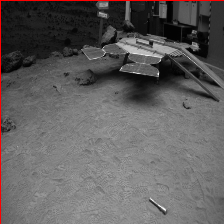

In [49]:
# visualizar nas imagens alguns dos y_pred em X_val

show_image_bbox(X_val[0], y_pred[0], 'tinyTreal_N25.png')  # real

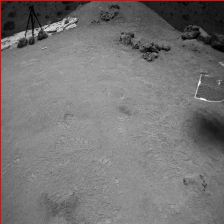

In [50]:
show_image_bbox(X_val[3], y_pred[3], 'tinyTreal_N44.png')  # real

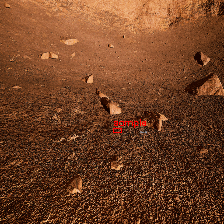

In [ ]:
show_image_bbox(X_val[6], y_pred[6], 'tinyTsyn_N44.png')   # synthetic

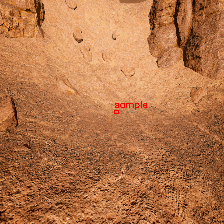

In [ ]:
show_image_bbox(X_val[15], y_pred[15], 'tinyTsyn_N72.png') # synthetic

##**Sexto passo:** Intersection over union (IoU)

**Intersection over union: metric to measure localization accuracy**

In [ ]:
def intersection_over_union(bboxA, bboxB):

    # bbox = [xmin, ymin, xmax, ymax]
    xmin = max(bboxA[0], bboxB[0])
    ymin = max(bboxA[1], bboxB[1])
    xmax = min(bboxA[2], bboxB[2])
    ymax = min(bboxA[3], bboxB[3])

    intersection_width = xmax - xmin
    intersection_height = ymax - ymin

    if intersection_width <= 0 or intersection_height <= 0:
      return 0

    intersection_area = intersection_width * intersection_height

    bboxA_area = (bboxA[2] - bboxA[0]) * (bboxA[3] - bboxA[1])
    bboxB_area = (bboxB[2] - bboxB[0]) * (bboxB[3] - bboxB[1])

    union_area = bboxA_area + bboxB_area - intersection_area

    IoU = intersection_area / union_area

    return IoU

In [ ]:
iou_sum = 0
iou_above_0 = []

for i in range(len(y_val)):
    iou = intersection_over_union(y_val[i], y_pred[i])

    if iou > 0:
       iou_above_0.append(i)

       iou_sum += iou
       iou_mean = iou_sum / len(y_val)

iou_mean, iou_above_0

(0.005576961480663406, [0, 16, 24, 41])

## **Sétimo passo:** Data Augmentation com albumentations.ai
(está todo confuso e não organizado)

**Fazer uma pipeline de transformações, 80/20 para train e valid (?) :**

In [ ]:
# antes de adicionar as imagens transformadas aos conjuntos, as shapes de X_train e X_valid são
# respetivamente (591, 224, 224, 3), (66, 224, 224, 3)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(591, 224, 224, 3) (591, 4) (66, 224, 224, 3) (66, 4)


In [ ]:
def transform_images(X_set, bbox_set):

    bbox_set = list(bbox_set)
    X_transformed = []
    bbox_transformed = []

    for i in range(len(bbox_set)):

        bbox_set[i] = list(bbox_set[i])
        bbox_set[i].append('sample')

    transform = A.Compose([A.RandomCrop(width=100, height=100)],   # aumentar esta pipeline e fazer outras diferentes
                          bbox_params=A.BboxParams(format='albumentations'))

    for i in range(X_set.shape[0]):

        transformed = transform(image=X_set[i], bboxes=[bbox_set[i]])
        transformed_image = transformed['image']
        transformed_bbox = transformed['bboxes']

        X_transformed.append(transformed_image)
        bbox_transformed.append(transformed_bbox)

    for i in range(len(bbox_transformed)):

        if bbox_transformed[i] != []:
          bbox_transformed[i] = list(bbox_transformed[i][0])
          bbox_transformed[i].remove('sample')

    return X_transformed, bbox_transformed

In [ ]:
random.seed(42)
transf_X_train, transf_y_train = transform_images(X_train[:10], y_train[:10])

In [ ]:
transf_y_train

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [0.8120698254364089, 0.0, 0.9182044887780549, 0.0752993348115298],
 [0.21464671654197842,
  0.061441241685144164,
  0.3133333333333334,
  0.13345898004434587],
 []]

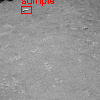

In [ ]:
show_image_bbox(transf_X_train[8], transf_y_train[8], 'transformedTreal_N10.png')

(ainda não está acabado, é necessário fazer isto para todas as imagens de X_train e depois X_val)

##**Passo:**

## **Sétimo passo:** Data Augmentation com albumentations.ai
(está menos confuso e melhor organizado)

**Fazer uma pipeline de transformações, 80/20 para train e valid (?) :**

In [ ]:
# antes de adicionar as imagens transformadas aos conjuntos, as shapes de X_train e X_valid são
# respetivamente (591, 224, 224, 3), (66, 224, 224, 3)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(591, 224, 224, 3) (591, 4) (66, 224, 224, 3) (66, 4)


In [ ]:
def transform_images(X_set, bbox_set, transform):

    bbox_set = list(bbox_set)
    X_transformed = []
    bbox_transformed = []

    for i in range(len(bbox_set)):

        bbox_set[i] = list(bbox_set[i])
        bbox_set[i].append('sample')

    for i in range(X_set.shape[0]):

        transformed = transform(image=X_set[i], bboxes=[bbox_set[i]])
        transformed_image = transformed['image']
        transformed_bbox = transformed['bboxes']

        X_transformed.append(transformed_image)
        bbox_transformed.append(transformed_bbox)

    for i in range(len(bbox_transformed)):

        if len(bbox_transformed[i]) != 0:
          bbox_transformed[i] = list(bbox_transformed[i][0])
          bbox_transformed[i].remove('sample')

    # retirar as imagens onde o tubo não está presente

    X_train_transf = []
    y_train_transf = []

    for i, bbox in enumerate(bbox_transformed):

        if len(bbox) != 0:
          X_train_transf.append(X_transformed[i])
          y_train_transf.append(bbox)

    return np.array(X_train_transf), np.array(y_train_transf)

In [ ]:
# efetuamos três transformações diferentes em todo o X_train e y_train
# no final, fazemos concat dos novos elementos de X_train e y_train

random.seed(42)
transform_1 = A.Compose([A.RandomCrop(width=100, height=100)],
                      bbox_params=A.BboxParams(format='albumentations'))

transform_2 = transform_1

transform_3 = transform_1

transformed_X_train_1, transformed_y_train_1 = transform_images(X_train, y_train, transform_1)
transformed_X_train_2, transformed_y_train_2 = transform_images(X_train, y_train, transform_2)
transformed_X_train_3, transformed_y_train_3 = transform_images(X_train, y_train, transform_3)

# para conseguir este concat, é necessário terem todas as mesma shape que X_train

X_train_final = np.concatenate([transformed_X_train_1,
                                transformed_X_train_2,
                                transformed_X_train_3
                                X_train])

y_train_final = np.concatenate([transformed_y_train_1,
                                transformed_y_train_2,
                                transformed_y_train_3,
                                y_train_real])


print(X_train_final.shape, y_train_final.shape)

In [ ]:
X_train_final.shape

(931, 100, 100, 3)

In [ ]:
# efetuamos outras três transformações diferentes em todo o X_val e y_val
# mais uma vez, concatenamos tudo para criar o novo X_val e y_val

random.seed(42)
transform_1 = A.Compose([A.RandomCrop(width=100, height=100)],
                      bbox_params=A.BboxParams(format='albumentations'))

transform_2 = 0

transform_3 = 0

transformed_X_val_1, transformed_y_val_1 = transform_images(X_val, y_val, transform_1)
transformed_Xv_val_2, transformed_y_val_2 = transform_images(X_val, y_val, transform_2)
transformed_X_val_3, transformed_y_val_3 = transform_images(X_val, y_val, transform_3)

X_val_final = np.concatenate([transformed_X_train_1,
                                transformed_X_train_2,
                                transformed_X_train_3,
                                X_train])

y_val_final = np.concatenate([transformed_y_val_1,
                              transformed_y_val_2,
                              transformed_y_val_3,
                              y_val_real])

print(X_val_final.shape, y_val_final.shape)

In [ ]:
len(transformed_X_train), len(transformed_y_train)

(2, 2)

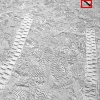

In [ ]:
show_image_bbox(transformed_X_train[0], transformed_y_train[0], 'transformedTreal_N10.png')

(ainda não está acabado, é necessário fazer isto para todas as imagens de X_train e depois X_val)

In [ ]:
transformed_y_train

array([[0.81206983, 0.        , 0.91820449, 0.07529933],
       [0.21464672, 0.06144124, 0.31333333, 0.13345898]])

In [ ]:
a = np.array([[1,2]])
b = np.array([[2,3]])
c = np.array([[3,4]])

a_b = np.concatenate([a,b,c])
a_b

array([[1, 2],
       [2, 3],
       [3, 4]])